In [3]:
import os, sys

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

# standard scientific python module
import scipy as sp
import scipy.stats as st
import scipy.optimize as op

# standard symbolic algebra module
import sympy as sm
sm.init_printing()

# module to save results
import joblib as jb

# pytorch
import torch
import torch.nn as nn

# split data into a training set and a test set
from sklearn.model_selection import train_test_split
# linearly transform a feature to zero mean and unit variance
from sklearn.preprocessing import StandardScaler

# to reload modules
import importlib

%matplotlib inline

# update fonts
FONTSIZE = 18
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility
#seed = 128
#rnd  = np.random.RandomState(seed)

from torch.utils.data import Dataset
import aliutils as utils

In [2]:
df = pd.read_csv('Data.csv')
df.head()

,Unnamed: 0,rawRecoDatapT,rawRecoDataeta,rawRecoDataphi,rawRecoDatam,RecoDatapT,RecoDataeta,RecoDataphi,RecoDatam,genDatapT,genDataeta,genDataphi,genDatam,tau
0,0,29.0586,3.511970,1.503010,5.69919,40.3892,3.41479,1.47023,12.53740,45.4608,3.379820,1.470130,13.24440,0.536525
1,1,47.9465,0.776638,-1.251970,6.72517,40.3892,3.41479,1.47023,12.53740,56.2643,0.811412,-1.324120,10.55060,0.130536
2,2,29.5200,-1.084730,1.834230,4.06446,29.3586,-1.17862,1.84039,9.95503,34.6377,-1.131020,1.801820,7.65844,0.500162
3,3,23.2719,-2.822960,0.216718,3.50878,20.9593,2.13374,-2.86886,9.55921,27.4120,-2.842550,0.345529,5.18675,0.490624
4,4,30.4644,2.985000,1.306930,4.11101,35.2909,2.96499,1.36464,10.69580,30.3263,3.040300,1.341270,5.74890,0.417064


In [3]:
df = df.iloc[:,5:]
df.head()

,RecoDatapT,RecoDataeta,RecoDataphi,RecoDatam,genDatapT,genDataeta,genDataphi,genDatam,tau
0,40.3892,3.41479,1.47023,12.53740,45.4608,3.379820,1.470130,13.24440,0.536525
1,40.3892,3.41479,1.47023,12.53740,56.2643,0.811412,-1.324120,10.55060,0.130536
2,29.3586,-1.17862,1.84039,9.95503,34.6377,-1.131020,1.801820,7.65844,0.500162
3,20.9593,2.13374,-2.86886,9.55921,27.4120,-2.842550,0.345529,5.18675,0.490624
4,35.2909,2.96499,1.36464,10.69580,30.3263,3.040300,1.341270,5.74890,0.417064


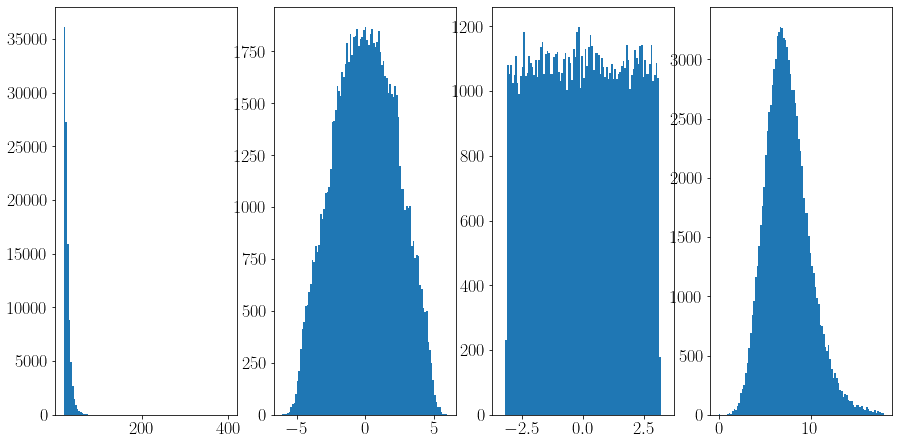

In [118]:
fig, ax = plt.subplots(1,4, figsize=(15,7.5))
ax[0].hist(df.RecoDatapT,bins=100)
ax[1].hist(df.RecoDataeta,bins=100)
ax[2].hist(df.RecoDataphi,bins=100, range=(-3.4,3.4))
ax[3].hist(df.RecoDatam,bins=100, range=(0,18))
plt.show()

In [79]:
levels = ['genData', 'RecoData']
kinematics=['pT','eta','phi','m']
targets = kinematics#for reco level, but same names
Networks = ['RecoNN', 'genNN']
gen_features=['genDatapT','genDataeta','genDataphi','genDatam', 'tau']
target = 'RecoDatapT'

def features_data(data):
    print('\nTarget:', target )
    features = gen_features
    if target== 'RecoDatapT':
        features.extend([target])
    elif target=='RecoDataeta':
        features.extend(['RecoDatapT',target])
    elif target=='RecoDataphi':
        features.extend(['RecoDatapT','RecoDataeta',target])
    elif target=='RecoDatam':
        features.extend(['RecoDatapT','RecoDataeta','RecoDataphi',target])
    
    
    print('\nFeatures:', features)
    return features
# target = df['RecoDatapT'].to_numpy()
# data =  df.drop('RecoDatapT', axis=1).to_numpy()
# data

In [80]:
df=pd.read_csv('Data.csv')
features=features_data(df)


Target: RecoDatapT

Features: ['genDatapT', 'genDataeta', 'genDataphi', 'genDatam', 'tau', 'RecoDatapT']


In [81]:
data=df[features]

In [82]:
data.head()

,genDatapT,genDataeta,genDataphi,genDatam,tau,RecoDatapT
0,45.4608,3.379820,1.470130,13.24440,0.536525,40.3892
1,56.2643,0.811412,-1.324120,10.55060,0.130536,40.3892
2,34.6377,-1.131020,1.801820,7.65844,0.500162,29.3586
3,27.4120,-2.842550,0.345529,5.18675,0.490624,20.9593
4,30.3263,3.040300,1.341270,5.74890,0.417064,35.2909


In [51]:
fraction = 20/100
# Split data into a part for training and a part for testing
train_data, test_data = train_test_split(data, 
                                         test_size=fraction)

# Split the training data into a part for training (fitting) and
# a part for validating the training.
fraction = 5/80
train_data, valid_data = train_test_split(train_data, 
                                          test_size=fraction)

# reset the indices in the dataframes and drop the old ones
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)
test_data  = test_data.reset_index(drop=True)

print('train set size:        %6d' % train_data.shape[0])
print('validation set size:   %6d' % valid_data.shape[0])
print('test set size:         %6d' % test_data.shape[0])

scaler_t = StandardScaler()
scaler_t.fit(train_data[target].to_numpy().reshape(-1, 1))


train set size:         75000
validation set size:     5000
test set size:          20000


KeyError: 'RecoDatpT'

In [45]:
scaler_t = StandardScaler()
scaler_t.fit(train_data[target].to_numpy().reshape(-1, 1))

# create a scaler for inputs
scaler_x = StandardScaler()
scaler_x.fit(train_data[features])
# NB: undo scaling of tau, which is the last feature
scaler_x.mean_[-1] = 0
scaler_x.scale_[-1]= 1

scalers = [scaler_t, scaler_x]

train_t, train_x = utils.split_t_x(train_data, target, features, scalers)
valid_t, valid_x = utils.split_t_x(valid_data, target, features, scalers)
test_t,  test_x  = utils.split_t_x(test_data,  target, features, scalers)

print('TARGETS ARE', train_t)
print()
print('TRAINING FEATURES', train_x)

print(train_t.shape, train_x.shape)


TARGETS ARE [-0.63459902 -0.63459902 -1.23465818 ... -0.22249789 -1.41638445
 -1.41638445]

TRAINING FEATURES [[-0.81046936  0.49595667  0.63914897 ...  0.62729692 -0.63459902
   5.94327   ]
 [-0.3418727   1.34342696 -1.11547965 ...  0.61823672 -1.23465818
   4.44499   ]
 [ 3.6886802  -0.53923955 -0.40370582 ... -0.99705221  0.61784846
   9.07049   ]
 ...
 [-0.45407957  0.36909337  1.01489441 ...  1.01870082  0.12831091
   7.84817   ]
 [-0.46854575  0.8261901   1.16838102 ...  1.18679877 -0.22249789
   6.97224   ]
 [-0.69929852  0.34198625 -0.44733982 ... -0.4479505  -1.41638445
   3.99124   ]]
(150000,) (75000, 21)
